#### Objective of this Notebook: 

Replicate the DenseNet Implentation and reproduce the (near) results obtained by the authors on CIFAR 10 image dataset using keras.

- DenseNet Paper: https://arxiv.org/pdf/1608.06993.pdf
- CIFAR10 Data : https://www.cs.toronto.edu/~kriz/cifar.html

#### Bullets(from the paper)

- Superficially, DenseNets are quite similar to ResNets: The previous outputs from the convulation layers are concatenated instead of summed. However, the implications of this seemingly small modification lead to substantially different behaviors of the two network architectures.

- Model compactness. As a direct consequence of the input concatenation, the feature-maps learned by any of the DenseNet layers can be accessed by all subsequent layers. This encourages feature reuse throughout the network, and leads to more compact models


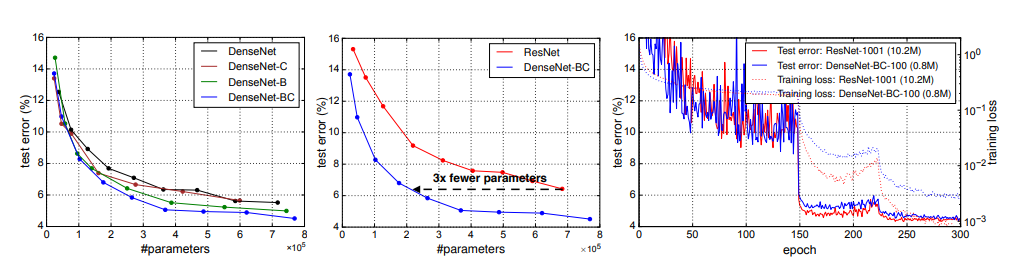

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
#
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
# Load CIFAR10 Data
(X_train_val, y_train_val), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('train images:', X_train_val.shape) # no.of samples * height * width * channels
print('test images:', X_test.shape) # no.of samples * height * width * channels

# convert labels to onehot-encoding 
y_train_val = tf.keras.utils.to_categorical(y_train_val, num_classes = 10)
y_test = tf.keras.utils.to_categorical(y_test, num_classes = 10)
print('train labels:', y_train_val.shape) # no.of samples * num_classes
print('test labels:', y_test.shape) # no.of samples * num_classes

170500096/170498071 [==============================] - 11s 0us/step
train images: (50000, 32, 32, 3)
test images: (10000, 32, 32, 3)
train labels: (50000, 10)
test labels: (10000, 10)


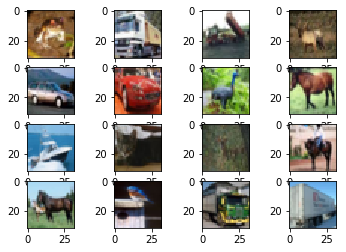

In [3]:
import matplotlib.pyplot as plt
for i in range(16):
    # define subplot
    plt.subplot(4, 4, i+1)
    # plot raw pixel data
    plt.imshow(X_train_val[i])
# show the figure
plt.show()

10 classes in CIFAR10 data: 
- airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size = 0.1)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((45000, 32, 32, 3), (5000, 32, 32, 3), (45000, 10), (5000, 10))

### Blocks of DenseNet

#### convolution (with bottleneck layer) = BatchNorm layer + activtion + bottleneck conv2D + conv2D with (3,3) filter (will used to produce dense_block).
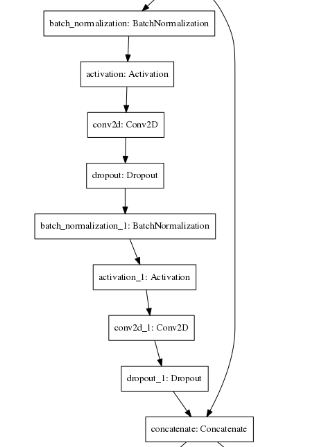

In [5]:
def bn_relu_convolution(x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
    """
    Creates a convolution layers consisting of BN-ReLU-Conv.
    Optional: bottleneck, dropout
    
    """
    # Bottleneck
    if bottleneck:
        bottleneckWidth = 4
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(nb_channels * bottleneckWidth, (1, 1),
                          kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
        # Dropout
        if dropout_rate:
            x = layers.Dropout(dropout_rate)(x)

    # BN-ReLU-Conv
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(nb_channels, (3, 3), padding='same')(x)

    # Dropout
    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)

    return x

#### transition = BatchNorm layer + activtion + convolution for compression + pooling layer (will used after each dense block)
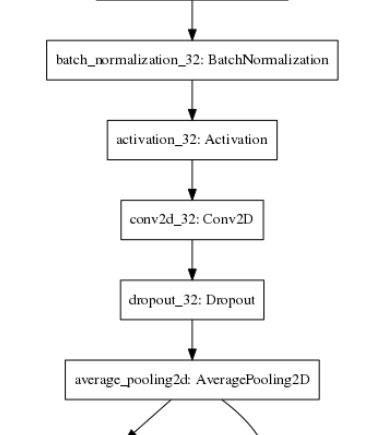

In [6]:
def bn_relu_transition(x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):
    """
    Creates a transition layer between dense blocks as transition, which do convolution and pooling.
    Works as downsampling.
    """

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu',)(x)
    x = layers.Convolution2D(int(nb_channels * compression), (1, 1), padding='same',
                             kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)

    # Adding dropout
    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)

    x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
    return x

#### dense_block = concatenated bn_relu_convolution layers.

In [7]:
def dense_block(x, num_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False,
                    weight_decay=1e-4):
    """
    Creates a dense block and concatenates inputs
    """

    for i in range(num_layers):
        cb = bn_relu_convolution(x, growth_rate, dropout_rate, 
                                 bottleneck) # 1 conv if bottleneck = 0 else 2 conv if bottleneck = 1
        nb_channels += growth_rate
        x = layers.concatenate([cb, x])
    return x, nb_channels

### DenseNet Model

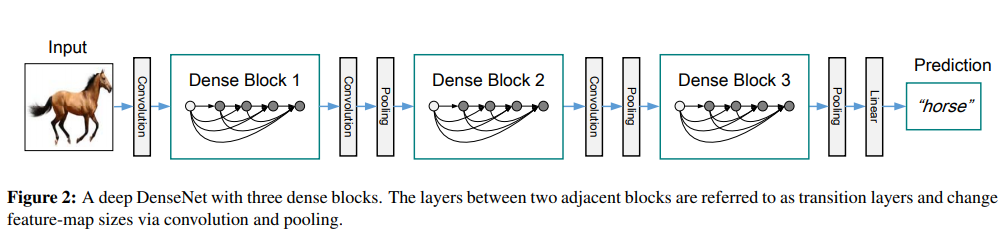

- (Input + Convolution) layers : Each input image is convoluted to depth of (2*growth_rate) before giveing it to dense_block.
- transition = (convolution + pooling) after each dense block except for last one where we use (pooling + dense) layers for prediction.

In [8]:
 def DenseNet(input_shape, dense_blocks, dense_layers, growth_rate, compression, bottleneck, 
                     weight_decay, dropout_rate, num_classes, ):
        """
        Build the model
        Returns: tf Keras Model instance
        """

        print('Creating DenseNet with Bottleneck = {}'.format(bottleneck))
        print('#############################################')
        print('No.of. dense blocks: %s' % dense_blocks)
        print('Layers per dense block: %s' % dense_layers)
        print('#############################################')

        # Input Layer
        img_input = layers.Input(shape=input_shape, name = 'img_input')
        nb_channels = growth_rate

        # Input-convolution layer
        x = layers.Conv2D(2 * growth_rate, (3, 3), padding='same', strides=(1, 1),name='input_conv', 
                          kernel_regularizer= tf.keras.regularizers.l2(weight_decay))(img_input)

        # Building dense blocks
        for block in range(dense_blocks - 1):
            # Add dense_block
            x, nb_channels = dense_block(x, dense_layers[block], nb_channels, growth_rate,
                                     dropout_rate, bottleneck, weight_decay) 

            # Add transition
            x = bn_relu_transition(x, nb_channels, dropout_rate, compression, weight_decay) # 1 conv layer
            nb_channels = int(nb_channels * compression)

        # Add last dense block without transition but with only global average pooling
        x, nb_channels = dense_block(x, dense_layers[-1], nb_channels,
                                          growth_rate, dropout_rate, weight_decay)
        
        # prediction of class happens here
        x = layers.BatchNormalization(name = 'prediction_bn')(x)
        x = layers.Activation('relu',  name = 'prediction_relu', )(x)
        x = layers.GlobalAveragePooling2D( name = 'prediction_pool', )(x)
        prediction = layers.Dense(num_classes, name = 'prediction_dense', activation='softmax')(x)

        return tf.keras.Model(inputs=img_input, outputs=prediction, name='densenet')

### generalised logic to calculate no.of layers (equal) in network:
  - This doesn't apply to DenseNet121 and Other DenseNet Architectures used for Imagenet DataSet - they have different no.of layers in dense block.
  - `dense_layers in each dense_block  = (Total_Depth - (num_dense_blocks + 1))/num_dense_blocks`
  - if bottlenecks layers are present then each conv_block in dense_block will have two conv2D layers then
    `dense_layers in each dense_block (for bottleneck) = (Total_Depth - (num_dense_blocks + 1))/num_dense_blocks * 2`
  
##### for 100 layer network with bottleneck & 3 dense blocks:

- num_layers in each dense_block:
    `100 - (3+1)/3*2 = 16`

##### for 101 layer network with bottleneck & 4 dense blocks:

- num_layers in each dense_block:
     `101 - (4+1)/8 = 12`

In [9]:
dense_net = DenseNet(input_shape = (32,32,3), dense_blocks = 3, dense_layers = [16]*3,
                     growth_rate = 12, compression = 0.5, num_classes = 10, bottleneck = True, 
                     dropout_rate = None, weight_decay = 1e-5)
# dense_net.summary()

Creating DenseNet with Bottleneck = True
#############################################
No.of. dense blocks: 3
Layers per dense block: [16, 16, 16]
#############################################


In [10]:
class DenseNet(object):
    
    def __init__(self,input_shape=None, dense_blocks=3, dense_layers=-1, growth_rate=12, num_classes=None,
                 dropout_rate=None, bottleneck=False, compression=1.0, weight_decay=1e-4, depth=40):
        
        # Parameters Check
        if num_classes == None:
            raise Exception(
                'Please define number of classes (e.g. num_classes=10). This is required to create .')

        if compression <= 0.0 or compression > 1.0:
            raise Exception('Compression have to be a value between 0.0 and 1.0.')

        if type(dense_layers) is list:
            if len(dense_layers) != dense_blocks:
                raise AssertionError('Number of dense blocks have to be same length to specified layers')
        elif dense_layers == -1:
            dense_layers = int((depth - 4) / 3)
            if bottleneck:
                dense_layers = int(dense_layers / 2)
            dense_layers = [dense_layers for _ in range(dense_blocks)]
        else:
            dense_layers = [dense_layers for _ in range(dense_blocks)]

        self.dense_blocks = dense_blocks
        self.dense_layers = dense_layers
        self.input_shape = input_shape
        self.growth_rate = growth_rate
        self.weight_decay = weight_decay
        self.dropout_rate = dropout_rate
        self.bottleneck = bottleneck
        self.compression = compression
        self.num_classes = num_classes
        
        
    def build_model(self):
        """
        Build the model
        Returns: tf Keras Model instance
        """
        if self.bottleneck:
            print('Creating DenseNet with Bottlenecks')
        else:
            print('Creating DenseNet without Bottlenecks')
        print('-' * 50)
        print('No.of. dense blocks: %s' % self.dense_blocks)
        print('Layers per dense block: %s' % self.dense_layers)
        print('-'* 50)

        # Input Layer
        img_input = layers.Input(shape = self.input_shape, name = 'img_input')
        nb_channels = self.growth_rate

        # Input-convolution layer
        x = layers.Conv2D(2 * self.growth_rate, (3, 3), padding='same', strides=(1, 1),name='input_conv', 
                          kernel_regularizer= tf.keras.regularizers.l2(self.weight_decay))(img_input)

        # Building dense blocks
        for block in range(self.dense_blocks - 1):
            # Add dense_block
            x, nb_channels = self.dense_block(x, self.dense_layers[block], nb_channels, self.growth_rate,
                                      self.dropout_rate, self.bottleneck, self.weight_decay) 

            # Add transition
            x = self.bn_relu_transition(x, nb_channels, self.dropout_rate, 
                                        self.compression, self.weight_decay) # 1 conv layer
            nb_channels = int(nb_channels * self.compression)

        # Add last dense block without transition but with only global average pooling
        x, nb_channels = self.dense_block(x, self.dense_layers[-1], nb_channels,
                                          self.growth_rate, self.dropout_rate, self.weight_decay)
        
        # prediction of class happens here
        x = layers.BatchNormalization(name = 'prediction_bn')(x)
        x = layers.Activation('relu',  name = 'prediction_relu', )(x)
        x = layers.GlobalAveragePooling2D( name = 'prediction_pool', )(x)
        prediction = layers.Dense(self.num_classes, name = 'prediction_dense', activation='softmax')(x)

        return tf.keras.Model(inputs=img_input, outputs=prediction, name='DenseNet')
        
        
    def dense_block(self, x, num_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False,
                    weight_decay=1e-4):
        """
        Creates a dense block and concatenates inputs
        """

        for i in range(num_layers):
            cb = self.bn_relu_convolution(x, growth_rate, dropout_rate, 
                                     bottleneck) # 1 conv if bottleneck = 0 else 2 conv if bottleneck = 1
            nb_channels += growth_rate
            x = layers.concatenate([cb, x])
        return x, nb_channels

        
    def bn_relu_convolution(self, x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
        """
        Creates a convolution layers consisting of BN-ReLU-Conv.
        Optional: bottleneck, dropout

        """
        # Bottleneck
        if bottleneck:
            bottleneckWidth = 4
            x = layers.BatchNormalization()(x)
            x = layers.Activation('relu')(x)
            x = layers.Conv2D(nb_channels * bottleneckWidth, (1, 1),
                              kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
            # Dropout
            if dropout_rate:
                x = layers.Dropout(dropout_rate)(x)

        # BN-ReLU-Conv
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(nb_channels, (3, 3), padding='same')(x)

        # Dropout
        if dropout_rate:
            x = layers.Dropout(dropout_rate)(x)

        return x

    def bn_relu_transition(self, x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):
        """
        Creates a transition layer between dense blocks as transition, which do convolution and pooling.
        Works as downsampling.
        """

        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu',)(x)
        x = layers.Convolution2D(int(nb_channels * compression), (1, 1), padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)

        # Adding dropout
        if dropout_rate:
            x = layers.Dropout(dropout_rate)(x)

        x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)
        return x

In [11]:
dense_net = DenseNet(input_shape = (32,32,3), dense_blocks = 3, dense_layers = [16]*3,
                     growth_rate = 12, compression = 0.5, num_classes = 10, bottleneck = True, 
                     dropout_rate = None, weight_decay = 1e-6).build_model()
dense_net.summary()

Creating DenseNet with Bottlenecks
--------------------------------------------------
No.of. dense blocks: 3
Layers per dense block: [16, 16, 16]
--------------------------------------------------
Model: "DenseNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_input (InputLayer)          [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
input_conv (Conv2D)             (None, 32, 32, 24)   672         img_input[0][0]                  
__________________________________________________________________________________________________
batch_normalization_98 (BatchNo (None, 32, 32, 24)   96          input_conv[0][0]                 
____________________________________________________________________________________________

In [12]:
from tensorflow.keras.callbacks import *

# to log results
csv_logger = CSVLogger('training_results.csv')

# top 5 acc
def top5_acc(y_true, y_pred):
    return tf.keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=5)


# model checkpoint
file_path='dense_net_cifar10.h5'
checkpoint = ModelCheckpoint(file_path, monitor='val_loss', verbose = 0, 
                             save_best_only=True, save_weights_only=True,
                             mode='min')

# reduce LR on plateau
lr_reduced = ReduceLROnPlateau(monitor='val_loss', mode='min', verbose = 0,
                               factor = 0.2, patience = 10, min_lr = 0.000001)

# determine Loss function and Optimizer
dense_net.compile(loss='categorical_crossentropy',
                  optimizer=Adam(),
                  metrics=['accuracy'],)

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, 
                                   horizontal_flip=True, vertical_flip=True)
train_datagen.fit(X_train)
train_data = train_datagen.flow(X_train, y_train, batch_size = 200)

In [14]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_datagen.fit(X_val)
val_data = val_datagen.flow(X_val, y_val, batch_size = 200)

In [15]:
# fits the model on batches with real-time data augmentation:
res_history = dense_net.fit_generator(train_data, epochs = 100,
                                      validation_data = (X_val/255.,y_val),
                                      callbacks = [checkpoint, lr_reduced, csv_logger])

Epoch 1/100
225/225 [==============================] - 205s 912ms/step - loss: 1.8449 - acc: 0.4449 - val_loss: 3.4306 - val_acc: 0.1410
Epoch 2/100
225/225 [==============================] - 86s 384ms/step - loss: 1.4351 - acc: 0.5845 - val_loss: 2.1577 - val_acc: 0.4504
Epoch 3/100
225/225 [==============================] - 87s 385ms/step - loss: 1.2324 - acc: 0.6498 - val_loss: 1.6366 - val_acc: 0.5446
Epoch 4/100
225/225 [==============================] - 86s 382ms/step - loss: 1.1097 - acc: 0.6849 - val_loss: 2.0153 - val_acc: 0.4736
Epoch 5/100
225/225 [==============================] - 87s 385ms/step - loss: 1.0159 - acc: 0.7143 - val_loss: 1.2256 - val_acc: 0.6484
Epoch 6/100
225/225 [==============================] - 86s 381ms/step - loss: 0.9356 - acc: 0.7392 - val_loss: 1.3307 - val_acc: 0.6224
Epoch 7/100
225/225 [==============================] - 87s 385ms/step - loss: 0.8714 - acc: 0.7581 - val_loss: 1.2129 - val_acc: 0.6450
Epoch 8/100
225/225 [==========================

In [16]:
import matplotlib.pyplot as plt
def draw_metric_plots(res):
    import pandas as pd
    df = pd.DataFrame()
    df['train_loss'] = res.history['loss']
    df['val_loss'] = res.history['val_loss']
    df['train_acc'] = res.history['acc']
    df['val_acc'] = res.history['val_acc']
    df.index = np.arange(1,len(df)+1,1)
    
    # draw Loss
    df[['train_loss', 'val_loss']].plot()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    # draw Acc
    df[['train_acc', 'val_acc']].plot()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    
    return df

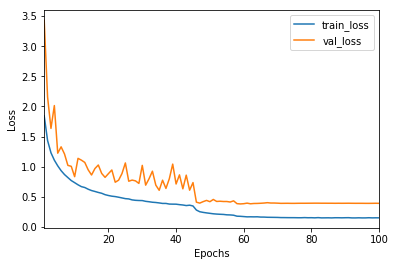

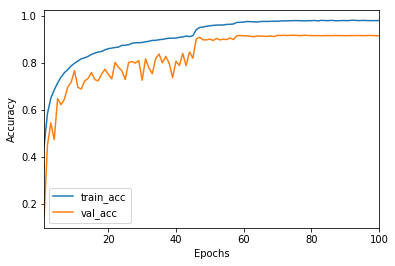

In [17]:
res_df = draw_metric_plots(res_history)

In [18]:
# y_test_probas = dense_net.predict(X_test/255.)
scores = dense_net.evaluate(X_test/255., y_test)
print(scores)

10000/10000 [==============================] - 8s 794us/sample - loss: 0.4273 - acc: 0.9025
[0.42734981541633604, 0.9025]


### Results

- Altough the training obtained are comparable to official paper, there is slight overfitting of the model.

In [19]:
dense_net.fit(X_train_val/255., y_train_val, epochs = 25)

Epoch 1/25
50000/50000 [==============================] - 159s 3ms/sample - loss: 0.2011 - acc: 0.9636
Epoch 2/25
50000/50000 [==============================] - 157s 3ms/sample - loss: 0.2005 - acc: 0.9630
Epoch 3/25
50000/50000 [==============================] - 154s 3ms/sample - loss: 0.2001 - acc: 0.9644
Epoch 4/25
50000/50000 [==============================] - 154s 3ms/sample - loss: 0.1966 - acc: 0.9654
Epoch 5/25
50000/50000 [==============================] - 154s 3ms/sample - loss: 0.1909 - acc: 0.9668
Epoch 6/25
50000/50000 [==============================] - 153s 3ms/sample - loss: 0.1936 - acc: 0.9663
Epoch 7/25
50000/50000 [==============================] - 154s 3ms/sample - loss: 0.1924 - acc: 0.9671
Epoch 8/25
27680/50000 [===============>..............] - ETA: 1:08 - loss: 0.1856 - acc: 0.9693

In [20]:
# y_test_probas = dense_net.predict(X_test/255.)
scores = dense_net.evaluate(X_test/255., y_test)
print(scores)

10000/10000 [==============================] - 8s 794us/sample - loss: 0.3744 - acc: 0.9147
[0.37439925191402434, 0.9147]


In [21]:
# from tensorflow.keras.utils import plot_model
# plot_model(dense_net, to_file='DenseNet.png')

In [22]:
#

In [23]:
#